In [1]:
import os
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger, TestTubeLogger
import torch
import wandb

from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision.transforms import Compose
from torch.nn import functional as F
import torchvision.models.resnet as resnet
import torch.nn as nn
from torchvision.datasets import Cityscapes
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import LambdaLR


from typing import Optional
import sys
import numpy as np
from PIL import Image
from tqdm import tqdm
import OpenEXR as exr
import Imath
from path import Path
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from dotenv import load_dotenv
import os
from datetime import datetime
import uuid

import pdb
from definitions import *

In [2]:
%matplotlib widget

In [3]:
# source.datasets.Dataset.ipynb

if 1:
    
    class DatasetMiniscapes(torch.utils.data.Dataset):
        '''
        This class read the Synscapes dataset
        '''
        def __init__(self, dataset_root, split_idx: list, integrity_check=False, override_transforms=None):
            '''
            dataset_root: root folder whose sub-folders are <class>,<depth>,<rgb>,.. so on
            split_idx: indices corresponding to the current dataset
            '''
            self.dataset_root = dataset_root
            self.split_idx = split_idx
            self.transforms = None
            if integrity_check:
                for i in tqdm(range(1,len(self)+1)):                    
                    self.get(i, override_transforms)
                    #print(f"Integrity check : {i} finished")
    
        def set_transforms(self, transforms):
            self.transforms = transforms
    
        def get(self, index, override_transforms=None):
            # load rgb, Image.open does not load contents of file in memory, it checks minimally
            rgb = Image.open(self.get_item_path(index, MOD_RGB))
            # Image.load() put the contents of file in memory
            rgb.load()
            assert rgb.mode == 'RGB'
    
            out = {
                MOD_ID: index,
                MOD_RGB: rgb,
            }
    
            # load semseg
            path_semseg = self.get_item_path(index, MOD_SEMSEG)
            if os.path.isfile(path_semseg):
                semseg = self.load_semseg(path_semseg)
                assert semseg.size == rgb.size
                out[MOD_SEMSEG] = semseg
    
            # load depth
            path_depth = self.get_item_path(index, MOD_DEPTH)
            if os.path.isfile(path_depth):
                # the depth map here is a np array object
                # we need to convert it to PIL object since transforms later on requires PIL object
                depth = self.load_exr(path_depth)
                disparity = self.depth_meters_float32_to_disparity_uint8(depth, out_of_range_policy='clamp_to_range')
                disparity_im = Image.fromarray(disparity)
                #assert depth.size == rgb.size
                out[MOD_DEPTH] = disparity_im #depth
                #out['disparity'] = disparity_im
    
            if override_transforms is not None:
                out = override_transforms(out)
            elif self.transforms is not None:
                out = self.transforms(out)
    
            return out
    
        def __getitem__(self, index):
            # index into the stored index in the object
            index_ = self.split_idx[index]
            return self.get(index_)
    
        def __len__(self):
            return len(self.split_idx)
    
        def get_item_path(self, index, modality):
            if modality == MOD_SEMSEG:
                modality = modality + "_filt"
                return self.dataset_root/modality/f'{index}{".exr" if modality == MOD_DEPTH else ".png"}'
            return self.dataset_root/modality/f'{index}{".exr" if modality == MOD_DEPTH else ".png"}'
    
        def name_from_index(self, index):
            return f'{index}'        
    
        @property
        def rgb_mean(self):
            # imagenet statistics used in pretrained networks - these are allowed to not match stats of this dataset
            return [255 * 0.485, 255 * 0.456, 255 * 0.406]
    
        @property
        def rgb_stddev(self):
            # imagenet statistics used in pretrained networks - these are allowed to not match stats of this dataset
            return [255 * 0.229, 255 * 0.224, 255 * 0.225]
    
        @staticmethod
        def load_semseg(filepath):
            semseg = Image.open(filepath)
            # L (8-bit pixels, grayscale), P (8-bit pixels, mapped to any other mode using a color palette)
            assert semseg.mode in ('P', 'L')
            return semseg
    
        @staticmethod
        def load_exr(filepath):
            exrfile = exr.InputFile(filepath)
            header = exrfile.header()
            dw = header['dataWindow']
            isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)
            channelData = dict()
            # convert all channels in the image to numpy arrays
            for c in header['channels']:
                C = exrfile.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
                C = np.frombuffer(C, dtype=np.float32)
                C = np.reshape(C, isize)
                channelData[c] = C
    
            Z = None if 'Z' not in header['channels'] else channelData['Z']
            return Z
    
        def depth_meters_float32_to_disparity_uint8(self, x, out_of_range_policy):
            assert out_of_range_policy in ('invalidate', 'clamp_to_range')
            x = np.array(x).astype(np.float32)
            # compute disparity from depth
            x = 1 / x
            disparity_min, disparity_max = 1 / self.depth_meters_max, 1 / self.depth_meters_min
            x = 1 + 254 * (x - disparity_min) / (disparity_max - disparity_min)
            if out_of_range_policy == 'invalidate':
                with np.errstate(invalid='ignore'):
                    x[x < 0.] = float('nan')
                    x[x > 255.] = float('nan')
                x[x != x] = 0
            elif out_of_range_policy == 'clamp_to_range':
                assert np.sum((x != x).astype(np.int32)) == 0
                x[x < 1.] = 1.
                x[x > 255.] = 255.
            x = x.astype(np.uint8)
            return x
    
        def depth_disparity_uint8_to_meters_float32(self, x, check_all_pixels_valid):
            assert type(check_all_pixels_valid) is bool
            mask_invalid = x == 0
            assert not check_all_pixels_valid or np.sum(mask_invalid.astype(np.int32)) == 0
            disparity_min, disparity_max = 1 / self.depth_meters_max, 1 / self.depth_meters_min
            x = (disparity_max - disparity_min) * (x - 1).astype(np.float32) / 254 + disparity_min
            x = 1.0 / x
            x[mask_invalid] = 0.0
            return x
    
        def save_depth(self, path, img, out_of_range_policy):
            assert torch.is_tensor(img) and (img.dim() == 2 or img.dim() == 3 and img.shape[0] == 1)
            if img.dim() == 3:
                img = img.squeeze(0)
            img = img.cpu().numpy()
            img = self.depth_meters_float32_to_disparity_uint8(img, out_of_range_policy)
            img = Image.fromarray(img)
            img.save(path, optimize=True)
    
        @staticmethod
        def save_semseg(path, img, semseg_color_map, semseg_ignore_label=None, semseg_ignore_color=(0, 0, 0)):
            if torch.is_tensor(img):
                img = img.squeeze()
                assert img.dim() == 2 and img.dtype in (torch.int, torch.long)
                img = img.cpu().byte().numpy()
                img = Image.fromarray(img, mode='P')
            palette = [0 for _ in range(256 * 3)]
            for i, rgb in enumerate(semseg_color_map):
                for c in range(3):
                    palette[3 * i + c] = rgb[c]
            if semseg_ignore_label is not None:
                for c in range(3):
                    palette[3 * semseg_ignore_label + c] = semseg_ignore_color[c]
            img.putpalette(palette)
            img.save(path, optimize=True)
    
        @property
        def semseg_num_classes(self):
            return len(self.semseg_class_names)
    
        @property
        def semseg_class_names(self):
            return [clsdesc.name for clsdesc in Cityscapes.classes if not clsdesc.ignore_in_eval]
    
        @property
        def semseg_class_colors(self):
            return [clsdesc.color for clsdesc in Cityscapes.classes if not clsdesc.ignore_in_eval]
    
        @property
        def semseg_ignore_label(self):
            return 255
        
        @property
        def depth_meters_mean(self):
            return 27.0727
    
        @property
        def depth_meters_stddev(self):
            return 29.1264
    
        @property
        def depth_meters_min(self):
            return 4
    
        @property
        def depth_meters_max(self):
            return 300
    
         

In [4]:
dbg = []
dbg_before = []

In [5]:
# source/utils/transforms.py

if 1:
    class Identity:
        def __call__(self, sample):
            return sample
    
    # This class just makes the image W,H as multiple of "multiple" and crops the valid area
    class CropForPassableSidesPIL:
        def __init__(self, multiple):
            self.multiple = multiple
    
        def __call__(self, sample):
            assert MOD_RGB in sample, f'{__class__} needs to know canvas size'
            width, height = sample[MOD_RGB].size
            width_new = self.multiple * (width // self.multiple)
            height_new = self.multiple * (height // self.multiple)
            assert width_new > 0 and height_new > 0, 'Bad input dimensions'
            for modality in sample.keys():
                data = sample[modality]
                if isinstance(data, Image.Image):
                    data = data.crop((0, 0, width_new, height_new))
                    sample[modality] = data
            return sample
    
    class _RandomScaledTiltedWarpedPIL:
        def __init__(
                self, dst_size, random_scale_min, random_scale_max,
                random_tilt_max_deg, random_wiggle_max_ratio, random_reflect,
                semseg_ignore_label, center_offset_instead_of_random
        ):
            assert isinstance(dst_size, int) or isinstance(dst_size, tuple), f'Invalid type of dst_size {type(dst_size)}'
            self.dst_size = dst_size if isinstance(dst_size, tuple) else (dst_size, dst_size) #(W,H)
            self.random_scale_min = random_scale_min
            self.random_scale_max = random_scale_max
            self.random_tilt_max_deg = random_tilt_max_deg
            self.random_wiggle_max_ratio = random_wiggle_max_ratio
            self.random_reflect = random_reflect
            self.semseg_ignore_label = semseg_ignore_label
            self.center_offset_instead_of_random = center_offset_instead_of_random
    
        def __call__(self, sample):
            assert MOD_RGB in sample, f'{__class__} needs to know canvas size'
            src_size = sample[MOD_RGB].size
            dst_corners = [
                np.array([0, 0], dtype=np.float32),
                np.array([0, self.dst_size[1]], dtype=np.float32),
                np.array([self.dst_size[0], self.dst_size[1]], dtype=np.float32),
                np.array([self.dst_size[0], 0], dtype=np.float32)
            ]
            if self.random_reflect:
                do_reflect = np.random.random() < 0.5
                if do_reflect:
                    dst_corners = list(reversed(dst_corners))
            src_corners, src_scale = _RandomScaledTiltedWarpedPIL._generate_corners(
                src_size, self.dst_size, self.random_scale_min, self.random_scale_max,
                self.random_tilt_max_deg, self.random_wiggle_max_ratio,
                self.center_offset_instead_of_random,
            )
            warp_coef_inv = _RandomScaledTiltedWarpedPIL._perspective_transform_from_corners(dst_corners, src_corners)
    
            for modality in sample.keys():
                interp = INTERP[modality]
                data = sample[modality]
                if interp is None:
                    continue
                elif interp in ('nearest', 'bilinear'):
                    assert isinstance(data, Image.Image), f'Input must be PIL.Image, found {type(data)}'
                    interp_pil = {
                        'nearest': Image.NEAREST,
                        'bilinear': Image.BILINEAR,
                    }[interp]
                    fill_color = {
                        MOD_RGB: None,
                        MOD_SEMSEG: self.semseg_ignore_label,
                        MOD_DEPTH: None, #float('nan'),
                    }[modality]
                    
                    if modality == MOD_SEMSEG:
                        #print(np.array(data).min(), np.array(data).max(), data.size)
                        dbg_before.append((np.array(data).min(), np.array(data).max()))
                        
                        
                    data = data.transform(
                        self.dst_size, Image.PERSPECTIVE, warp_coef_inv, interp_pil, fillcolor=fill_color
                    )
                    if modality == MOD_SEMSEG:
                        dbg.append((np.array(data).min(), np.array(data).max()))
                        #print(np.array(data).min(), np.array(data).max(), data.size)
                        #pdb.set_trace()
                    
                else:
                    assert False, f'Unknown interp {interp}'
                sample[modality] = data
    
            return sample
    
        # adopted from https://stackoverflow.com/questions/14177744/how-does-perspective-transformation-work-in-pil
        # arguments must be lists of tuples like [(x_tl, y_tl), (x_bl, y_bl), (x_br, y_br), (x_tr, y_tr)] with frame of
        # reference in the top-left corner of the image
        @staticmethod
        def _perspective_transform_from_corners(corners_src, corners_dst): # find coeff to take corners_dst -> corners_src
            matrix = []
            for p_src, p_dst in zip(corners_src, corners_dst):
                matrix.append([p_src[0], p_src[1], 1, 0, 0, 0, -p_dst[0] * p_src[0], -p_dst[0] * p_src[1]])
                matrix.append([0, 0, 0, p_src[0], p_src[1], 1, -p_dst[1] * p_src[0], -p_dst[1] * p_src[1]])
            A = np.matrix(matrix, dtype=np.float64)
            B = np.array(corners_dst).reshape(8)
            res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
            return np.array(res, dtype=np.float32).reshape(8)
    
        @staticmethod
        def _dst_corners_bounding_box(corners):
            '''
            corners: list of np array
            '''
            x_min, x_max = corners[0][0], corners[0][0]
            y_min, y_max = corners[0][1], corners[0][1]
            for corner in corners[1:]:
                x_min = min(x_min, corner[0])
                x_max = max(x_max, corner[0])
                y_min = min(y_min, corner[1])
                y_max = max(y_max, corner[1])
            return x_min, x_max, y_min, y_max
    
        @staticmethod
        def _transform_scale_rotate_wiggle(dst_size, scale_min, scale_max, angle_max_deg, wiggle_max_ratio):
            corners = [
                np.array([-dst_size[0] / 2, -dst_size[1] / 2], dtype=np.float32),
                np.array([-dst_size[0] / 2, dst_size[1] / 2], dtype=np.float32),
                np.array([dst_size[0] / 2, dst_size[1] / 2], dtype=np.float32),
                np.array([dst_size[0] / 2, -dst_size[1] / 2], dtype=np.float32)
            ] # these corners are defined w.r.t center of the image where going down and right is +ve axis from center
    
            # get the max wiggle in terms of pixels, NOTE: wiggle_max_ratio: [0, 1/2], so max wiggle is 1/4*min(W,H) of cropped size
            max_wiggle_pix = wiggle_max_ratio * min(dst_size[0], dst_size[1]) / 2
            scale = np.random.uniform(scale_min, scale_max)
            angle_deg = np.random.uniform(-angle_max_deg, angle_max_deg) if 0 < angle_max_deg <= 45 else 0
            
            # for each corner vertex, generate a wiggle factor for (w,h) cordinates
            wiggle_factor = [
                np.array([
                    np.random.uniform(-max_wiggle_pix, max_wiggle_pix),
                    np.random.uniform(-max_wiggle_pix, max_wiggle_pix)
                ], dtype=np.float32) for _ in range(4)
            ]
    
            angle_rad = np.deg2rad(angle_deg)
            matrix_rot = np.array([
                [np.cos(angle_rad), np.sin(-angle_rad)],
                [np.sin(angle_rad), np.cos(angle_rad)]
            ], dtype=np.float32)
    
             # wiggle is just added to crop size, wiggle is like adding random noise in corner positions of image so that crop size is not fixed
            corners = [np.matmul(matrix_rot, scale * (c + w)) for c, w in zip(corners, wiggle_factor)]
            return corners, scale
    
        @staticmethod
        def _generate_corners(
                src_size, dst_size, random_scale_min=1.0, random_scale_max=2.0,
                random_tilt_max_deg=0.0, random_wiggle_max_ratio=0.0, center_offset_instead_of_random=False
        ):
            assert random_scale_min > 0, 'random_scale_min must be positive'
            assert random_scale_max >= random_scale_min, 'random_scale_max > random_scale_min'
            assert random_tilt_max_deg >= 0, 'tilt must be non negative'
            assert 0 <= random_wiggle_max_ratio < 0.5, 'random_wiggle_max_ratio must be [0, 1/2]'
    
            corners, scale = _RandomScaledTiltedWarpedPIL._transform_scale_rotate_wiggle(
                dst_size, random_scale_min, random_scale_max, random_tilt_max_deg, random_wiggle_max_ratio
            )
            # Here we get the crop cordinates in the source image, note these will be w.r.t center at middle of cropped image
            x_min, x_max, y_min, y_max = _RandomScaledTiltedWarpedPIL._dst_corners_bounding_box(corners)
    
            # The code below add random offset to crop cordinates and ensures that cordinates are positive where origin is at top left of src image
            range_x_min = -x_min
            range_x_max = src_size[0] - x_max
            range_y_min = -y_min
            range_y_max = src_size[1] - y_max
    
            if center_offset_instead_of_random or range_x_max <= range_x_min:
                offs_x = (range_x_min + range_x_max) * 0.5
            else:
                offs_x = np.random.uniform(range_x_min, range_x_max)
    
            if center_offset_instead_of_random or range_y_max <= range_y_min:
                offs_y = (range_y_min + range_y_max) * 0.5
            else:
                offs_y = np.random.uniform(range_y_min, range_y_max)
    
            corners = [c + np.array([offs_x, offs_y], dtype=np.float32) for c in corners]
            return corners, scale
    
    class RandomScaledTiltedWarpedCropPIL(_RandomScaledTiltedWarpedPIL):
        def __init__(
                self, dst_size, random_scale_min, random_scale_max, random_tilt_max_deg, random_wiggle_max_ratio,
                random_reflect, semseg_ignore_label
        ):
            super(RandomScaledTiltedWarpedCropPIL, self).__init__(
                dst_size, random_scale_min, random_scale_max, random_tilt_max_deg,
                random_wiggle_max_ratio, random_reflect, semseg_ignore_label,
                center_offset_instead_of_random=False
            )
    
    class ConvertToTensorsSimple:
        def __call__(self, sample):
            for modality in sample.keys():
                data = sample[modality]
                if modality == MOD_ID:
                    data = torch.tensor(data, dtype=torch.long)
                elif modality == MOD_RGB:
                    data = torch.from_numpy(np.array(data)).float().permute(2, 0, 1) # dataset read images as PIL where channel is at end
                elif modality == MOD_SEMSEG:
                    data = torch.from_numpy(np.array(data)).long().unsqueeze(0) # add channel dim
                elif modality == MOD_DEPTH:
                    data = torch.from_numpy(np.array(data)).float().unsqueeze(0) # add channel dim
                else:
                    print(f'Unaccounted data, collate WILL complain: {modality} {data}')
                sample[modality] = data
            return sample
    
    class ZeroMeanUnitVarianceTensor:
        def __init__(self, modality, mean, stddev):
            self.modality = modality
            self.mean = mean
            self.stddev = stddev
    
        def __call__(self, sample):
            if self.modality not in sample:
                return sample
            assert torch.is_tensor(sample[self.modality])
            mean = torch.tensor(self.mean, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
            stddev = torch.tensor(self.stddev, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
            sample[self.modality] = (sample[self.modality] - mean) / stddev
            return sample
    
    
    
    def get_transforms(
        semseg_ignore_label=None,
        geom_scale_min=0.5,
        geom_scale_max=2.0,
        geom_tilt_max_deg=0,
        geom_wiggle_max_ratio=0,
        geom_reflect=True,
        crop_for_passable=0,
        crop_random=0,
        rgb_mean=None,
        rgb_stddev=None,
        depth_meters_mean=None,
        depth_meters_stddev=None,
    ):
        return Compose([
            RandomScaledTiltedWarpedCropPIL(
                crop_random,
                random_scale_min=geom_scale_min,
                random_scale_max=geom_scale_max,
                random_tilt_max_deg=geom_tilt_max_deg,
                random_wiggle_max_ratio=geom_wiggle_max_ratio,
                random_reflect=geom_reflect,
                semseg_ignore_label=semseg_ignore_label,
            ) if crop_random > 0 else Identity(),
            ConvertToTensorsSimple(),
            ZeroMeanUnitVarianceTensor(MOD_RGB, rgb_mean, rgb_stddev) if rgb_mean is not None else Identity(),
            # ZeroMeanUnitVarianceTensor(MOD_DEPTH, depth_meters_mean, depth_meters_stddev) if depth_meters_mean is not None else Identity(),
            # SafeLogTensor(MOD_DEPTH),
        ])

In [6]:
# first read all number of files in root/semseg, root/depth, root/rgb
root_dir = Path("C:/Sachin/CVAIAC2023/synscapes/Synscapes/img/")
flist_seg = glob.glob(root_dir/"semseg_filt/*.png")
flist_depth = glob.glob(root_dir/"depth/*.exr")
flist_cam = glob.glob(root_dir/"rgb/*.png")

assert len(flist_seg) == len(flist_depth), "number of files in class folder is not same as depth folder"
assert len(flist_seg) == len(flist_cam), "number of files in class folder is not same as cam folder"

num_datapts = len(flist_seg)
# create train, val, test indx
X_train, X_test, y_train, y_test = train_test_split(np.arange(1,num_datapts+1), np.arange(1,num_datapts+1), test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
train_idx = X_train
val_idx = X_val
test_idx = X_test
# create datasets

In [9]:
# construct dataset object and check the integrity check
train_ds = DatasetMiniscapes(root_dir, train_idx, integrity_check=True)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [12:50<00:00, 25.96it/s]


In [10]:
val_ds = DatasetMiniscapes(root_dir, val_idx, integrity_check=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:34<00:00, 26.57it/s]


In [11]:
test_ds = DatasetMiniscapes(root_dir, test_idx, integrity_check=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:33<00:00, 26.69it/s]


In [32]:
class Config():
    def __init__(self):
        # set up configs
        self.log_dir = "./LOG_DIR"
        self.dataset_root = "C:/Sachin/CVAIAC2023/synscapes/Synscapes/img/"
        self.name = "Seg-0"
        self.resume = None

        # batches, epochs
        self.batch_size = 4 # training
        self.num_epochs = 1
        self.batch_size_validation = 8

        # augmentations
        self.aug_input_crop_size = 256
        self.aug_geom_scale_min = 1
        self.aug_geom_scale_max = 1
        self.aug_geom_tilt_max_deg = 0
        self.aug_geom_wiggle_max_ratio = 0
        self.aug_geom_reflect = False

        # optimizers
        self.optimizer = "adam"
        self.optimizer_lr = 0.01 # at start of training
        self.optimizer_momentum = 0.9
        self.optimizer_weight_decay = 0.01
        self.optimizer_float_16 = False

        # scheduler
        self.lr_scheduler = 'poly' # polynomial scheduler, internally LambdaLR from torch is called which bring down lr at end of every epoch
        self.lr_scheduler_power = 0.9 # polynomial power for learning rate

        #self.dataset = ""  #choices=['miniscapes']
        self.tasks = "semseg"    #choices=['depth', 'semseg']
        
        self.model_name = "deeplabv3p" #choices=['deeplabv3p', 'deeplabv3p_multitask', 'adaptive_depth']
        self.model_encoder_name = 'resnet18' # choices=['resnet18', 'resnet34']
        self.pretrained = True # for self.model_encoder_name
        
        self.loss_weight_semseg = 0.5
        self.loss_weight_depth = 0.5
        
        self.workers = 16 # for train data
        self.workers_validation = 4 # for val data

        self.num_steps_visualization_first = 100 #visualization: first time step
        self.num_steps_visualization_interval = 1000 #Visualization: interval in steps
        self.visualize_num_samples_in_batch = 8 #Visualization: max number of samples in batch
        self.visualize_img_grid_width = 8 #Visualization: number of samples per row
        
        self.observe_train_ids =  None #'Visualization: train IDs' '[0,100]' ??
        self.observe_valid_ids = None # 'Visualization: valid IDs' '[0,100]' ??     

        
        self.prepare_submission = False

cfg = Config()


In [33]:
# check the integrity with transforms
# construct dataset object and check the integrity check
train_tfms = get_transforms(
            semseg_ignore_label=255,
            geom_scale_min=cfg.aug_geom_scale_min,
            geom_scale_max=cfg.aug_geom_scale_max,
            geom_tilt_max_deg=cfg.aug_geom_tilt_max_deg,
            geom_wiggle_max_ratio=cfg.aug_geom_wiggle_max_ratio,
            geom_reflect=cfg.aug_geom_reflect,
            crop_random=cfg.aug_input_crop_size,
            rgb_mean=[255 * 0.485, 255 * 0.456, 255 * 0.406],
            rgb_stddev=[255 * 0.229, 255 * 0.224, 255 * 0.225],
            depth_meters_mean=27.0727,
            depth_meters_stddev=29.1264,
        )
train_ds = DatasetMiniscapes(root_dir, train_idx, integrity_check=True, override_transforms=train_tfms)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [14:31<00:00, 22.96it/s]


In [34]:
min_dbg_before = np.array([x[0] for x in dbg_before])
max_dbg_before = np.array([x[1] for x in dbg_before])
min_dbg_before.min(), max_dbg_before.max()

(0, 255)

In [35]:
min_dbg = np.array([x[0] for x in dbg])
max_dbg = np.array([x[1] for x in dbg])
min_dbg.min(), max_dbg.max()

(0, 255)

In [30]:
train_ds.semseg_num_classes

19

In [31]:
train_ds.semseg_class_names

['road',
 'sidewalk',
 'building',
 'wall',
 'fence',
 'pole',
 'traffic light',
 'traffic sign',
 'vegetation',
 'terrain',
 'sky',
 'person',
 'rider',
 'car',
 'truck',
 'bus',
 'train',
 'motorcycle',
 'bicycle']

In [34]:
cls_name_id = [(clsdesc.name, clsdesc.id) for clsdesc in Cityscapes.classes if not clsdesc.ignore_in_eval]
cls_id = [clsdesc.id for clsdesc in Cityscapes.classes if not clsdesc.ignore_in_eval]
cls_name =  [clsdesc.name for clsdesc in Cityscapes.classes if not clsdesc.ignore_in_eval]
cls_name_id_ignore =  [(clsdesc.name, clsdesc.id) for clsdesc in Cityscapes.classes if clsdesc.ignore_in_eval]
cls_id_ignore = [clsdesc.id for clsdesc in Cityscapes.classes if clsdesc.ignore_in_eval]
cls_name_ignore =  [clsdesc.name for clsdesc in Cityscapes.classes if clsdesc.ignore_in_eval]
print(cls_name_id)

[('road', 7), ('sidewalk', 8), ('building', 11), ('wall', 12), ('fence', 13), ('pole', 17), ('traffic light', 19), ('traffic sign', 20), ('vegetation', 21), ('terrain', 22), ('sky', 23), ('person', 24), ('rider', 25), ('car', 26), ('truck', 27), ('bus', 28), ('train', 31), ('motorcycle', 32), ('bicycle', 33)]


In [33]:
[clsdesc.name for clsdesc in Cityscapes.classes], len([clsdesc.name for clsdesc in Cityscapes.classes])

(['unlabeled',
  'ego vehicle',
  'rectification border',
  'out of roi',
  'static',
  'dynamic',
  'ground',
  'road',
  'sidewalk',
  'parking',
  'rail track',
  'building',
  'wall',
  'fence',
  'guard rail',
  'bridge',
  'tunnel',
  'pole',
  'polegroup',
  'traffic light',
  'traffic sign',
  'vegetation',
  'terrain',
  'sky',
  'person',
  'rider',
  'car',
  'truck',
  'bus',
  'caravan',
  'trailer',
  'train',
  'motorcycle',
  'bicycle',
  'license plate'],
 35)

In [41]:
Cityscapes.classes

[CityscapesClass(name='unlabeled', id=0, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='ego vehicle', id=1, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='rectification border', id=2, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='out of roi', id=3, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='static', id=4, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='dynamic', id=5, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(111, 74, 0)),
 CityscapesClass(name='ground', id=6, train_id=255, category='void', category_id=0, has_instances=False, i

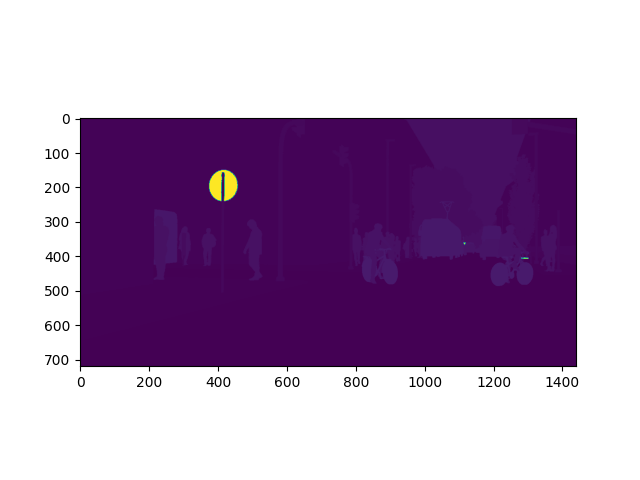

In [25]:
# load one semseg image
semimage_path = "C:/Sachin/CVAIAC2023/synscapes/Synscapes/img/semseg_filt/1.png"
semseg_filt = Image.open(semimage_path)
plt.figure()
plt.imshow(semseg_filt)

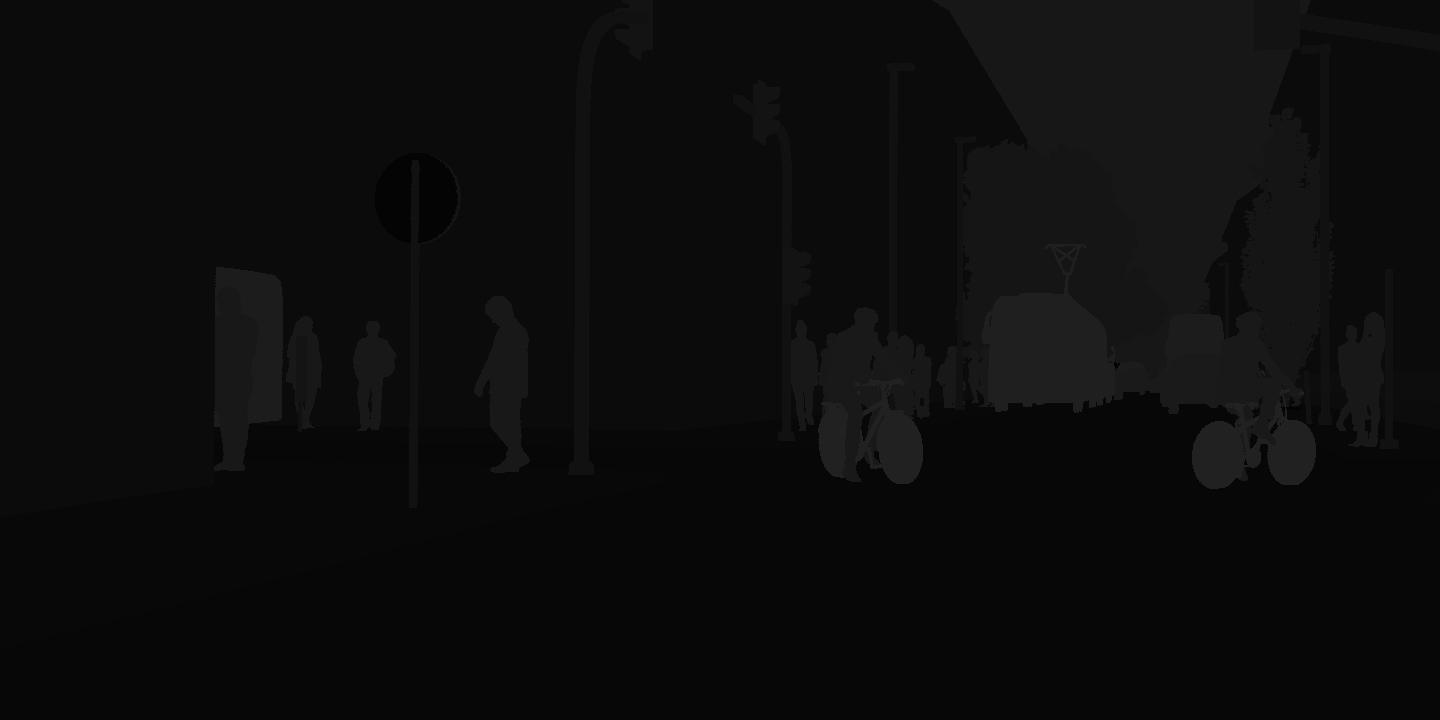

In [49]:
# load one semseg image
semimage_path = "C:/Sachin/CVAIAC2023/synscapes/Synscapes/img/semseg/1.png"
semseg = Image.open(semimage_path)
semseg

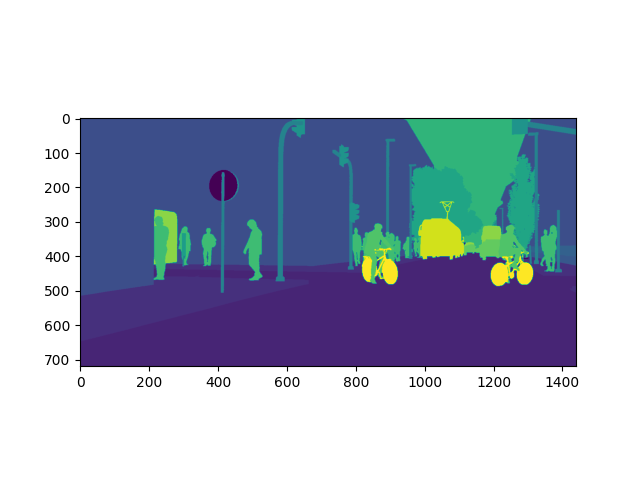

In [45]:
plt.figure()
plt.imshow(semseg)

In [51]:
semseg_ = np.array(semseg)
semseg_.shape, semseg.size

((720, 1440), (1440, 720))

In [35]:
# new class labels from [0,num_classes)
clsnametoid_new = {clsname:i for i, clsname in enumerate(cls_name)}
clsnametoid_old = {clsname:clsid for clsname, clsid in cls_name_id}
clsnametoid_ignore = {clsname:clsid for clsname, clsid in cls_name_id_ignore}
clsnametoid_new, clsnametoid_old, clsnametoid_ignore

({'road': 0,
  'sidewalk': 1,
  'building': 2,
  'wall': 3,
  'fence': 4,
  'pole': 5,
  'traffic light': 6,
  'traffic sign': 7,
  'vegetation': 8,
  'terrain': 9,
  'sky': 10,
  'person': 11,
  'rider': 12,
  'car': 13,
  'truck': 14,
  'bus': 15,
  'train': 16,
  'motorcycle': 17,
  'bicycle': 18},
 {'road': 7,
  'sidewalk': 8,
  'building': 11,
  'wall': 12,
  'fence': 13,
  'pole': 17,
  'traffic light': 19,
  'traffic sign': 20,
  'vegetation': 21,
  'terrain': 22,
  'sky': 23,
  'person': 24,
  'rider': 25,
  'car': 26,
  'truck': 27,
  'bus': 28,
  'train': 31,
  'motorcycle': 32,
  'bicycle': 33},
 {'unlabeled': 0,
  'ego vehicle': 1,
  'rectification border': 2,
  'out of roi': 3,
  'static': 4,
  'dynamic': 5,
  'ground': 6,
  'parking': 9,
  'rail track': 10,
  'guard rail': 14,
  'bridge': 15,
  'tunnel': 16,
  'polegroup': 18,
  'caravan': 29,
  'trailer': 30,
  'license plate': -1})

In [59]:
ignore_label = 255
semseg_ = np.array(semseg)
# first set the label of classes not in valid list to ingore_label
# loop over ignore ids and create ignoremask
prevmask = False * np.ones_like(semseg_)
for cls_name, cls_id in clsnametoid_ignore.items():
    currignoremask = semseg_ == cls_id
    ignoremask = currignoremask + prevmask
    prevmask = ignoremask
ignoremask[ignoremask>0] = True
semseg_[ignoremask.astype('bool')] = ignore_label

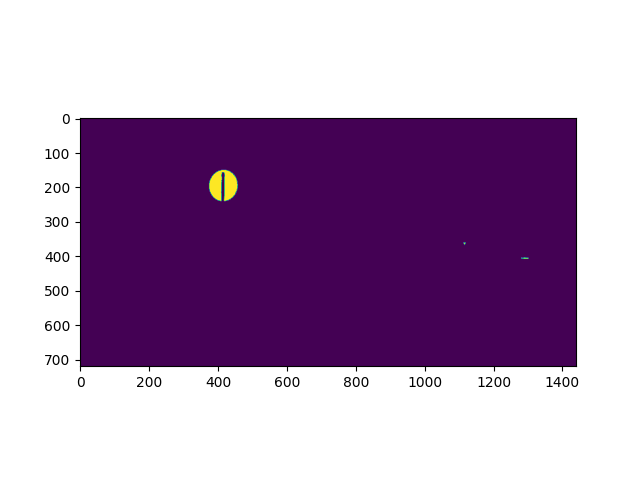

In [60]:
plt.figure()
plt.imshow(ignoremask)

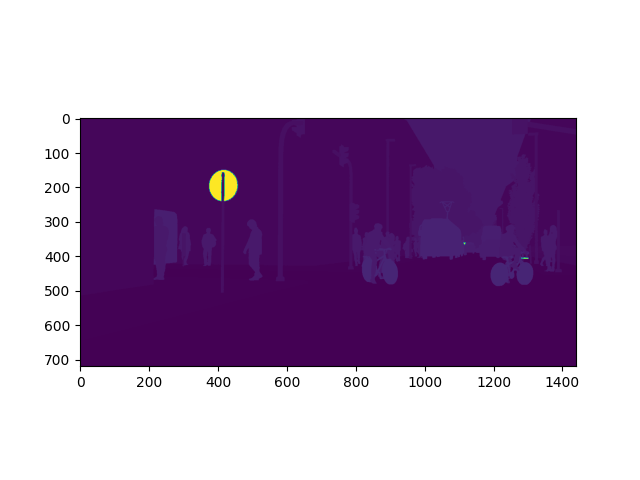

In [61]:
plt.figure()
plt.imshow(semseg_)

In [62]:
for cls_name, cls_id in clsnametoid_old.items():   
    # replace the old class labels with new class labels
    semseg_[semseg_ == cls_id] = clsnametoid_new[cls_name]

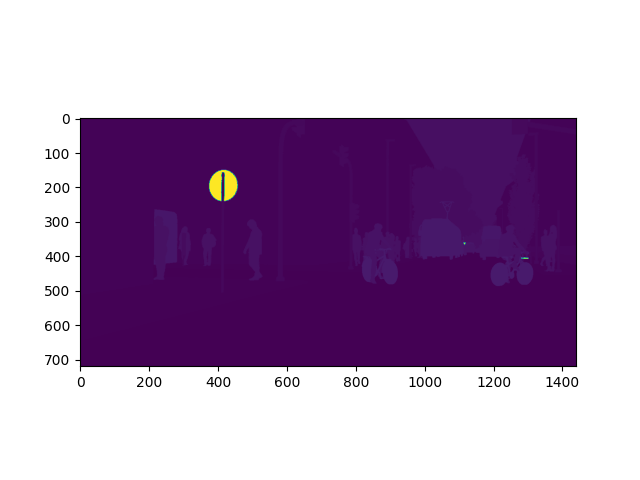

In [63]:
plt.figure()
plt.imshow(semseg_)

In [132]:
# calculate mask for each valid class we are interested in
prevmask = False * np.ones_like(semseg_)
masks = {}
for cls_name, cls_id in cls_name_id:
    print(cls_name, cls_id)
    currmask_ = semseg_ == cls_id
    masks[cls_id] = currmask_
    mask = currmask_ + prevmask
    prevmask = mask

mask[mask>0] = True
mask.sum()    

road 7
sidewalk 8
building 11
wall 12
fence 13
pole 17
traffic light 19
traffic sign 20
vegetation 21
terrain 22
sky 23
person 24
rider 25
car 26
truck 27
bus 28
train 31
motorcycle 32
bicycle 33


1031460

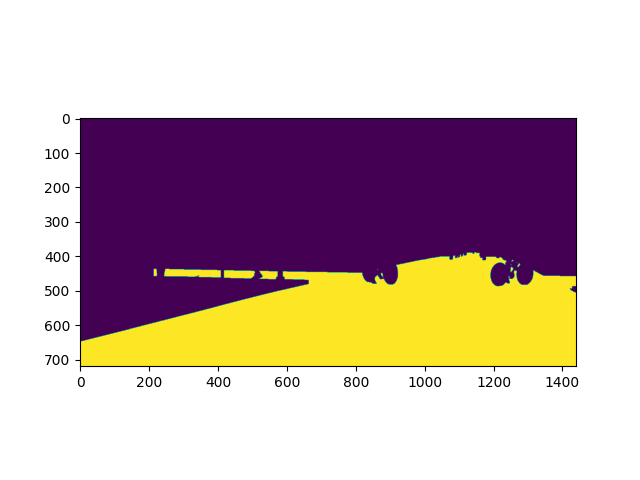

In [133]:
plt.figure()
plt.imshow(masks[7])

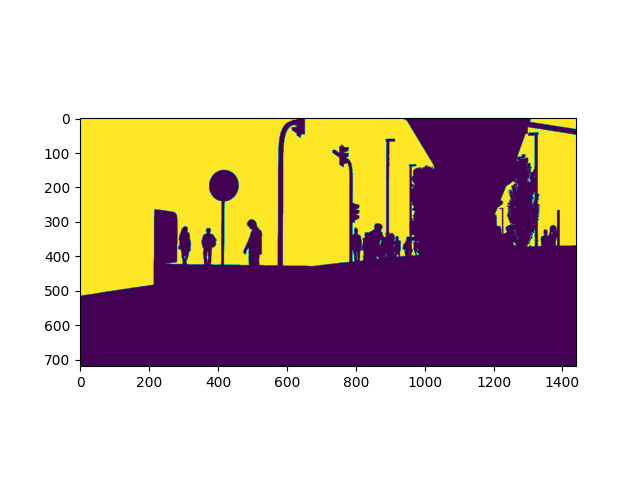

In [134]:
plt.figure()
plt.imshow(masks[11])

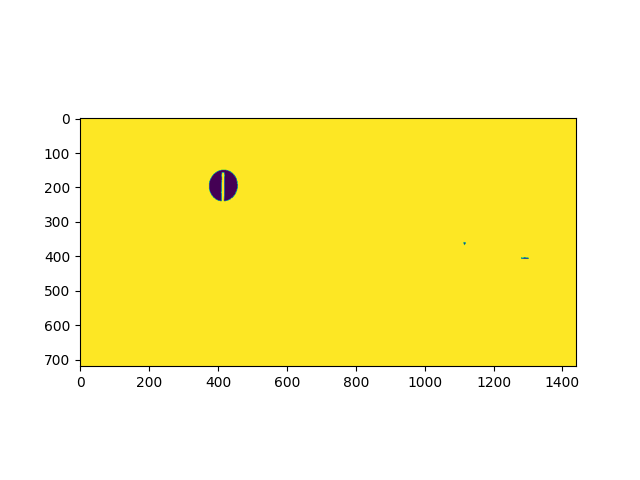

In [135]:
plt.figure()
plt.imshow(mask)

In [114]:
plt.close('all')

In [147]:
semseg_[~mask.astype('bool')] = 255

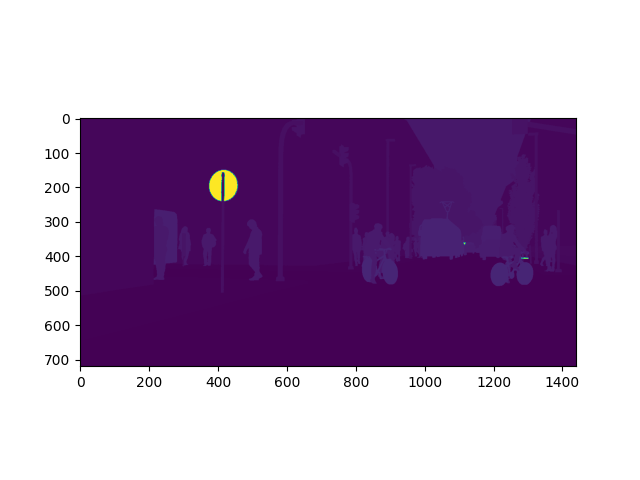

In [148]:
plt.figure()
plt.imshow(semseg_)

In [149]:
semseg_

array([[11, 11, 11, ..., 11, 11, 11],
       [11, 11, 11, ..., 11, 11, 11],
       [11, 11, 11, ..., 11, 11, 11],
       ...,
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  7]], dtype=uint8)

In [11]:
colors = torch.tensor([(155,255,155),(130,130,130)], dtype=torch.float32)

In [12]:
torch.max(colors)

tensor(255.)

In [13]:
# construct dataset object and check the integrity check
train_ds = DatasetMiniscapes(root_dir, train_idx, integrity_check=False)

In [14]:
sample = train_ds[0]

In [15]:
sample

{'id': 13294,
 'rgb': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1440x720 at 0x1CCBA71E490>,
 'semseg': <PIL.PngImagePlugin.PngImageFile image mode=L size=1440x720 at 0x1CCBA71E5E0>,
 'depth': <PIL.Image.Image image mode=L size=1440x720 at 0x1CCBA6B7340>}

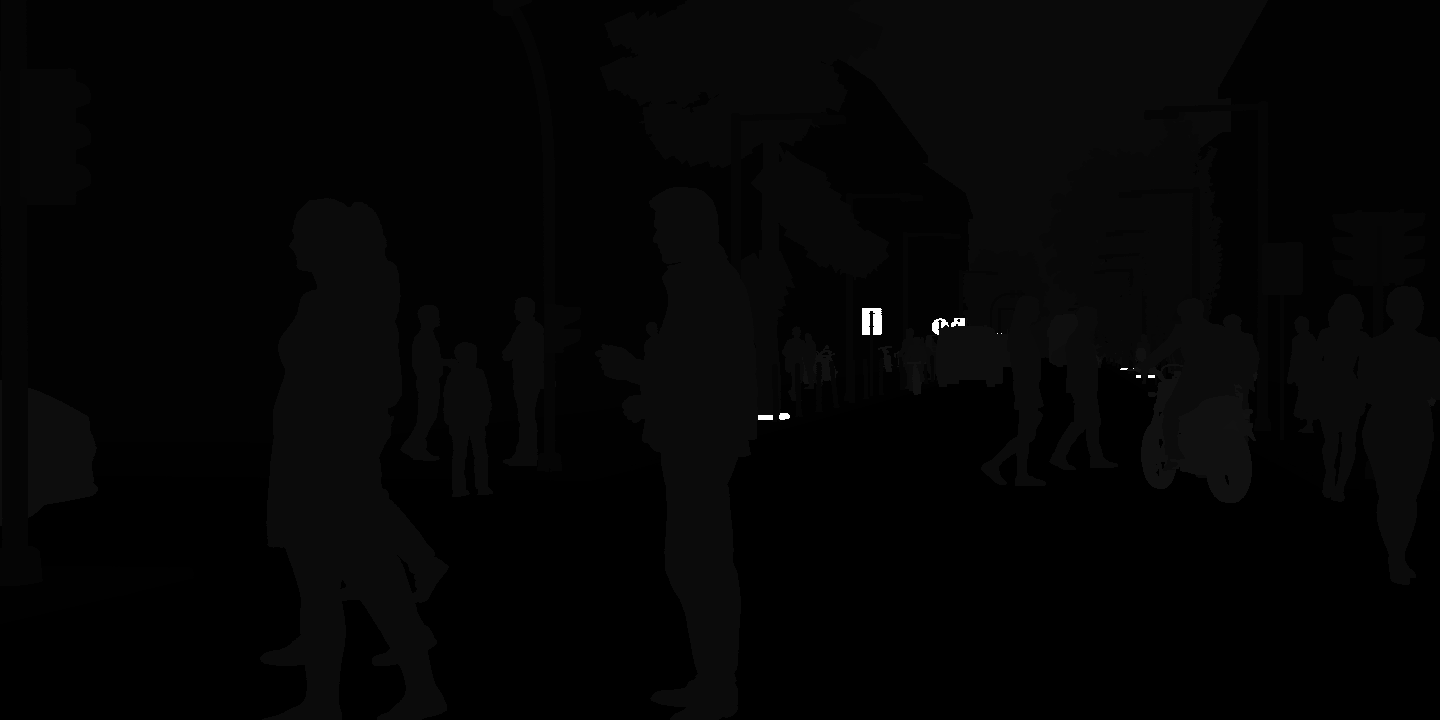

In [77]:
semseg_im = sample['semseg']
semseg_im

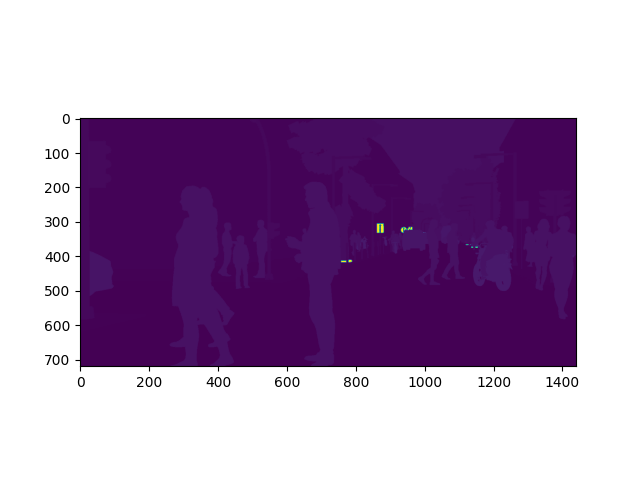

In [78]:
plt.figure()
plt.imshow(semseg_im)

In [79]:
semseg_im.size

(1440, 720)

In [80]:
semseg_im = np.array(semseg_im)

In [81]:
semseg_color_map = train_ds.semseg_class_colors
semseg_color_map

[(128, 64, 128),
 (244, 35, 232),
 (70, 70, 70),
 (102, 102, 156),
 (190, 153, 153),
 (153, 153, 153),
 (250, 170, 30),
 (220, 220, 0),
 (107, 142, 35),
 (152, 251, 152),
 (70, 130, 180),
 (220, 20, 60),
 (255, 0, 0),
 (0, 0, 142),
 (0, 0, 70),
 (0, 60, 100),
 (0, 80, 100),
 (0, 0, 230),
 (119, 11, 32)]

In [82]:
colors = torch.tensor(semseg_color_map, dtype=torch.float32)
colors

tensor([[128.,  64., 128.],
        [244.,  35., 232.],
        [ 70.,  70.,  70.],
        [102., 102., 156.],
        [190., 153., 153.],
        [153., 153., 153.],
        [250., 170.,  30.],
        [220., 220.,   0.],
        [107., 142.,  35.],
        [152., 251., 152.],
        [ 70., 130., 180.],
        [220.,  20.,  60.],
        [255.,   0.,   0.],
        [  0.,   0., 142.],
        [  0.,   0.,  70.],
        [  0.,  60., 100.],
        [  0.,  80., 100.],
        [  0.,   0., 230.],
        [119.,  11.,  32.]])

In [83]:
if torch.max(colors) > 128: # find max color
    colors /= 255

In [84]:
colors

tensor([[0.5020, 0.2510, 0.5020],
        [0.9569, 0.1373, 0.9098],
        [0.2745, 0.2745, 0.2745],
        [0.4000, 0.4000, 0.6118],
        [0.7451, 0.6000, 0.6000],
        [0.6000, 0.6000, 0.6000],
        [0.9804, 0.6667, 0.1176],
        [0.8627, 0.8627, 0.0000],
        [0.4196, 0.5569, 0.1373],
        [0.5961, 0.9843, 0.5961],
        [0.2745, 0.5098, 0.7059],
        [0.8627, 0.0784, 0.2353],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5569],
        [0.0000, 0.0000, 0.2745],
        [0.0000, 0.2353, 0.3922],
        [0.0000, 0.3137, 0.3922],
        [0.0000, 0.0000, 0.9020],
        [0.4667, 0.0431, 0.1255]])

In [85]:
img_color_ids = torch.unique(torch.tensor(semseg_im))
img_color_ids

tensor([  0,   1,   2,   5,   6,   7,   8,  10,  11,  12,  13,  14,  15,  17,
         18, 255], dtype=torch.uint8)

In [88]:
semseg_ignore_label = 255
semseg_im = torch.Tensor(semseg_im)
semseg_im = semseg_im.type(torch.long)
# replace ignore label with 0
mask_ignore = semseg_im == semseg_ignore_label
semseg_im[mask_ignore] = 0
semseg_im = semseg_im.unsqueeze(-1)
semseg_im.shape

torch.Size([720, 1440, 1])

In [91]:
img = colors[semseg_im]
img.size()

torch.Size([720, 1440, 1, 3])

In [92]:
def create_checkerboard(N, C, H, W):
    cell_sz = max(min(H, W) // 32, 1)
    mH = (H + cell_sz - 1) // cell_sz
    mW = (W + cell_sz - 1) // cell_sz
    checkerboard = torch.full((mH, mW), 0.25, dtype=torch.float32)
    checkerboard[0::2, 0::2] = 0.75
    checkerboard[1::2, 1::2] = 0.75
    checkerboard = checkerboard.float().view(1, 1, mH, mW)
    checkerboard = F.interpolate(checkerboard, scale_factor=cell_sz, mode='nearest')
    checkerboard = checkerboard[:, :, :H, :W].repeat(N, C, 1, 1)
    return checkerboard
checkerboard = create_checkerboard(1, 3, 720, 1440)

In [94]:
mask_ignore = mask_ignore.unsqueeze(0).repeat(3,1,1)
mask_ignore.shape

torch.Size([3, 720, 1440])